In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv("DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("DailyDelhiClimateTest.csv")

In [19]:
significant_features = ['meantemp', 'humidity', 'wind_speed']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[significant_features])
test_scaled = scaler.transform(test_df[significant_features])


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

def create_test_sequences(train_tail, test_data, seq_length):
    full = np.concatenate([train_tail[-seq_length:], test_data], axis=0)
    X = []
    for i in range(len(test_data)):
        X.append(full[i:i+seq_length])
    return np.array(X)

In [20]:
SEQ_LEN = 30
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test = create_test_sequences(train_scaled, test_scaled, SEQ_LEN)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(test_scaled[:X_test.shape[0], 0])  # meantemp column

# Создание DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [22]:
# Определение модели LSTM
class WeatherLSTM(nn.Module):
    def __init__(self, input_size=len(significant_features), hidden_size=124, output_size=1):
        super(WeatherLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 64, batch_first=True)
        self.linear = nn.Linear(64, output_size)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Берем только последний временной шаг
        return self.linear(x)

In [23]:
model = WeatherLSTM()
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [25]:
# Обучение модели
epochs = 20
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss_value = loss(outputs.squeeze(), batch_y)
        loss_value.backward()
        optimizer.step()
    
    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train[-len(X_train)//10:])  # 10% для валидации
        val_loss = loss(val_outputs.squeeze(), y_train[-len(y_train)//10:])
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_value.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch 1/20, Loss: 0.0036, Val Loss: 0.0033
Epoch 2/20, Loss: 0.0070, Val Loss: 0.0032
Epoch 3/20, Loss: 0.0067, Val Loss: 0.0038
Epoch 4/20, Loss: 0.0064, Val Loss: 0.0034
Epoch 5/20, Loss: 0.0055, Val Loss: 0.0039
Epoch 6/20, Loss: 0.0014, Val Loss: 0.0031
Epoch 7/20, Loss: 0.0032, Val Loss: 0.0022
Epoch 8/20, Loss: 0.0047, Val Loss: 0.0040
Epoch 9/20, Loss: 0.0038, Val Loss: 0.0023
Epoch 10/20, Loss: 0.0012, Val Loss: 0.0025
Epoch 11/20, Loss: 0.0015, Val Loss: 0.0021
Epoch 12/20, Loss: 0.0015, Val Loss: 0.0021
Epoch 13/20, Loss: 0.0039, Val Loss: 0.0017
Epoch 14/20, Loss: 0.0032, Val Loss: 0.0020
Epoch 15/20, Loss: 0.0021, Val Loss: 0.0034
Epoch 16/20, Loss: 0.0029, Val Loss: 0.0020
Epoch 17/20, Loss: 0.0085, Val Loss: 0.0029
Epoch 18/20, Loss: 0.0038, Val Loss: 0.0020
Epoch 19/20, Loss: 0.0119, Val Loss: 0.0023
Epoch 20/20, Loss: 0.0027, Val Loss: 0.0028


In [36]:
# Тестирование модели
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = loss(test_predictions.squeeze(), y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0035


In [37]:
def inverse(preds):
    pad = np.zeros((preds.shape[0], len(significant_features) - 1))
    full = np.concatenate([preds, pad], axis=1)
    return scaler.inverse_transform(full)[:, 0]

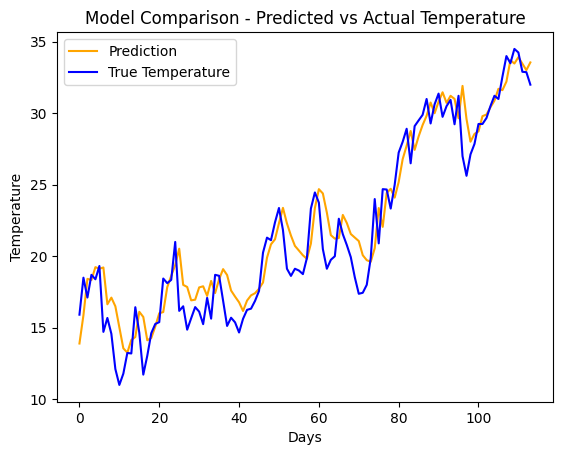

In [53]:
preds_inv = inverse(test_predictions)
true_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), len(significant_features)-1))], axis=1))[:, 0]
fig, ax = plt.subplots()
plt.plot(preds_inv, label=f"Prediction", color='orange')
plt.plot(true_inv, label="True Temperature", color='blue')
plt.legend()
plt.title("Model Comparison - Predicted vs Actual Temperature")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.show()